This is the main file for feature comparisons and hyperparameters optimization

In [10]:
# import functions
import importlib
import functions
importlib.reload(functions)
from functions import *

import features

In [11]:
# import extracted features
baseline = pd.read_csv('features/baseline.csv')
fft = pd.read_csv('features/fft.csv')
ti = pd.read_csv('features/ti.csv')
rolloff = pd.read_csv('features/rolloff.csv')
psd = pd.read_csv('features/psd.csv')
wt = pd.read_csv('features/wavelets.csv')

pre-processing every features

In [12]:
baseline_X_train, y_train, baseline_X_test, y_test = pre_features(0.8, baseline)
fft_X_train, y_train, fft_X_test, y_test = pre_features(0.8, fft)
ti_X_train, y_train, ti_X_test, y_test = pre_features(0.8, ti)
rolloff_X_train, y_train, rolloff_X_test, y_test = pre_features(0.8, rolloff)
psd_X_train, y_train, psd_X_test, y_test = pre_features(0.8, psd)
wt_X_train, y_train, wt_X_test, y_test = pre_features(0.8, wt)

fit every feature by knn

In [22]:
# store result of all the features
result = {}

In [23]:
%%time
result['baseline train'] = simple_knn(baseline_X_train, y_train, baseline_X_train, y_train)
result['baseline cv'] = knn_cv(baseline_X_train, y_train, baseline_X_test, y_test, 5)
result['baseline test'] = simple_knn(baseline_X_train, y_train, baseline_X_test, y_test)
result['fft train'] = simple_knn(fft_X_train, y_train, fft_X_train, y_train)
result['fft cv'] = knn_cv(fft_X_train, y_train, fft_X_test, y_test, 5)
result['fft test'] = simple_knn(fft_X_train, y_train, fft_X_test, y_test)
result['ti train'] = simple_knn(ti_X_train, y_train, ti_X_train, y_train)
result['ti cv'] = knn_cv(ti_X_train, y_train, ti_X_test, y_test, 5)
result['ti test'] = simple_knn(ti_X_train, y_train, ti_X_test, y_test)
result['rolloff train'] = simple_knn(rolloff_X_train, y_train, rolloff_X_train, y_train)
result['rolloff cv'] = knn_cv(rolloff_X_train, y_train, rolloff_X_test, y_test, 5)
result['rolloff test'] = simple_knn(rolloff_X_train, y_train, rolloff_X_test, y_test)
result['psd train'] = simple_knn(psd_X_train, y_train, psd_X_train, y_train)
result['psd cv'] = knn_cv(psd_X_train, y_train, psd_X_test, y_test, 5)
result['psd test'] = simple_knn(psd_X_train, y_train, psd_X_test, y_test)
result['wave train'] = simple_knn(wt_X_train, y_train, wt_X_train, y_train)
result['wave cv'] = knn_cv(wt_X_train, y_train, wt_X_test, y_test, 5)
result['wave test'] = simple_knn(wt_X_train, y_train, wt_X_test, y_test)

Wall time: 5min 57s


result

In [24]:
result_df = pd.DataFrame(list(result.items()), columns=['feature', 'F1'])
# change the format of result
result_table = {'Feature': ['Baseline', 'FFT', 'Temporal Integration', 'Rolloff', 'PSD', 'Wavelet'],
        'Train Score': list(result_df[result_df.index % 3 == 0]['F1']),
        'CV Score': list(result_df[result_df.index % 3 == 1]['F1']),
        'Test Score': list(result_df[result_df.index % 3 == 2]['F1']),}
table_df = pd.DataFrame(result_table)
table_df

,Feature,Train Score,CV Score,Test Score
0,Baseline,0.316850,0.165343,0.157829
1,FFT,0.752233,0.705255,0.689554
2,Temporal Integration,0.755761,0.700256,0.701010
3,Rolloff,0.453324,0.326963,0.333845
4,PSD,0.706107,0.644738,0.648339
5,Wavelet,0.677312,0.609627,0.608275


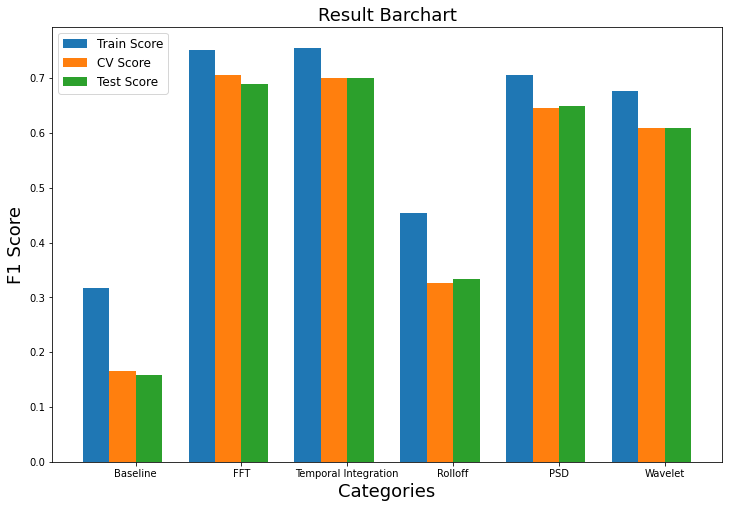

In [25]:
# Display
plt.figure(figsize=(12, 8))
bar_width = 0.25  # Adjust as needed
bar_positions = range(len(table_df['Feature']))

plt.bar(bar_positions, table_df['Train Score'], width=bar_width, label='Train Score')
# plt.bar([pos + bar_width for pos in bar_positions], table_df['cv_score_2'], width=bar_width, label='cv score 2')
plt.bar([pos + bar_width for pos in bar_positions], table_df['CV Score'], width=bar_width, label='CV Score')
plt.bar([pos + 2*bar_width for pos in bar_positions], table_df['Test Score'], width=bar_width, label='Test Score')

# Adding labels and title
plt.xlabel('Categories', fontsize=18)
plt.ylabel('F1 Score', fontsize=18)
plt.title('Result Barchart', fontsize=18)

# Adding legend
plt.legend(fontsize='large')

# Adjusting x-axis ticks and labels
plt.xticks([pos + 1.5*bar_width for pos in bar_positions], table_df['Feature'])

# Display the chart
plt.show()

looks like Temporal Integration is the best feature 

Optimise the hyperparameter, number of neighbours and weights

In [26]:
%%time
ns = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
weights = ['uniform', 'distance']
grid_search_stft = grid_search_cv(ti_X_train, y_train, ns, weights, 5)

Wall time: 9min 40s


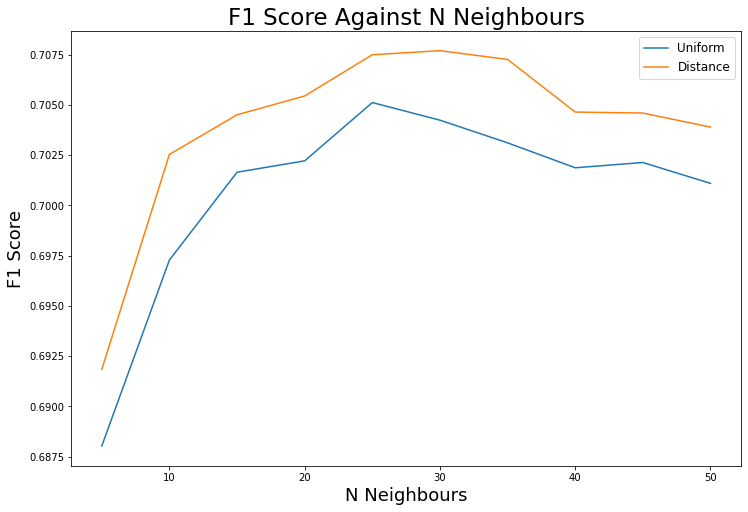

the best result of stft when use distance for n is 30, which is 0.7076935552947077


In [27]:
# print the curve
plt.figure(figsize=(12, 8))
plt.plot(ns, list(grid_search_stft.values())[0], label='Uniform')
plt.plot(ns, list(grid_search_stft.values())[1], label='Distance')
plt.title('F1 Score Against N Neighbours',fontsize=23)
plt.xlabel('N Neighbours',fontsize=18)
plt.ylabel('F1 Score',fontsize=18)
plt.legend(fontsize='large')
plt.show()

# locate the best parameter
best_weight = max(grid_search_stft, key=lambda k: max(enumerate(grid_search_stft[k]), key=lambda x: x[1])[1])
best_n = ns[max(enumerate(grid_search_stft[best_weight]), key=lambda x: x[1])[0]]
max_result = max((max(lst) for lst in grid_search_stft.values()))

print(f'the best result of stft when use {best_weight} for n is {best_n}, which is {max_result}')

In [28]:
# the best model
knn_classifier = KNeighborsClassifier(n_neighbors=best_n, weights=best_weight)

# Train the classifier on the training data
knn_classifier.fit(ti_X_train, y_train)

# Make predictions 
y_pred_train = knn_classifier.predict(ti_X_train)
y_pred_test = knn_classifier.predict(ti_X_test)

# Evaluate the accuracy of the classifier
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print(f'Fitting F1 score on training set is {f1_train}, on testing set is {f1_test}.')

# check whether its overfitted
if f1_train > f1_test:
    print('The model is overfitted.')
else:
    print('The model is not overfitted.')

Fitting F1 score on training set is 1.0, on testing set is 0.7070600446887575.
The model is overfitted.
